# Lecture 7: Endogenous portfolios and risk premia


Adrien Auclert and Tomas Tapak

Goethe Heterogeneous-Agent Macro Workshop

June 2024


This notebook walks us through the solution of the HANK model with portfolio choice covered in lecture, which is based off Auclert, Rognlie, Straub and Tapak "[When do Endogenous Portfolios Matter for HANK?](http://web.stanford.edu/~aauclert/hank_portfolios.pdf)" (2024 working paper)

Steps: 
1. Set up the exogenous portfolio model in SSJ with two shocks ($r^{ante}$, $B$) and get impulse responses with exogenous portfolios
2. Perform the "$\lambda$-test" for optimality of exogenous portfolios given each shock
3. Construct the complete market correction for the Jacobian of the HA block and get impulse responses with endogenous portfolios
4. Recover the complete-market transfers and associated portfolios
5. Compute the steady-state risk premia


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sequence_jacobian as sj

In [2]:
# Plot options
plt.rc('axes', grid=True, axisbelow=True)
plt.rc('grid', linestyle='--', linewidth=0.5, alpha=0.5)
plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (12,8)})

We'll load routines from `sim_steady_state_fast.py`, which was covered in earlier lectures, as well as special routines for complete-market correction in `sim_fake_news_correction.py`, which we will cover in this notebook. 

In [3]:
import sim_steady_state_fast as sim
import sim_portfolio_correction as sim_corr

## 0. Model recap

As described in the lecture, the model is a version of the canonical HANK model with sticky wages and a fixed markup $\mu$. Households can invest in real one-period bonds, which are in 0 net supply, or in equity, which is a claim to firm dividends.  

The household problem is to choose consumption, savings and portfolio allocation to maximize utility

$$
\begin{aligned}\max \ & \mathbb{E}_{\mathrm{o}}\sum_{t=0}^{\infty}\beta^{t}\left(u\left(c_{it}\right)-v\left(n_{it}\right)\right)\\
 & c_{it}+\sum_j a_{j,it}+b_{it}\leq \sum_j \left(1+r_{j,t}\right)a_{j,it-1}+e_{it}\left(1-\tau_{t}\right)w_{t}n_{it}\\
 & \sum a_{j,it}\equiv a_{it}\geq0
\end{aligned}
$$

$a_{j ,i t} \equiv$  position in asset $j$, $r_{j,i t} \equiv$ real return on asset $j$, $\tau_t \equiv$ tax rate, $w_t \equiv$ wage. 

Here there are two assets $j$ with different returns $r_j$
- **Real bond**: $r^{\mathrm{real}}_t = r^{\mathrm{ante}}_{t-1}$ where $r^{\mathrm{ante}}$ is the exogenous real interest rate, set by the central bank
- **Equity**: $r^{\mathrm{eq}}_{t}=\frac{p_t + d_t}{p_{t-1}}-1$ where $d_t$ is the dividend paid from firm profits, i.e. $d_t = Y_t - w_t N_t = (1-\tau_t)(1-1/\mu) Y_t$

We denote with a simple $r$ the return on the household's **exogenous baseline portfolio**. 

We assume here that this exogenous baseline portfolio is made up of $100\%$ equity, so $r_t = r^{\mathrm{eq}}_t$. 

We will now proceed in two steps. First we solve the model with exogenous portfolios, where the household chooses consumption, savings and invests in all of its savings in equity. Then we solve the model with endogenous portfolios, where the household chooses consumption, savings and portfolio allocation. We will start with the complete markets case,then consider incomplete markets and gross constraints on portfolio positions.

## 1. Exogenous portfolios

Using the substitutions made in class, writing $T_t = \tau_t Y_t$ for total real tax revenue and $Z_t = Y_t - T_t$ for disposable income, the model is characterized by the following equations, for $t\geq 0$, 


$$
\begin{aligned}
 \left(1+r_{t-1}^{\mathrm{ante}}\right)B_{t-1} & = T_{t} + B_{t} \\
 Z_t & = Y_t - T_t \\
 1+r_{t}^{\mathrm{ante}} & = \frac{p_{t+1}+(1-1/\mu)Z_{t+1}}{p_{t}} \\
 1+r_t & = \frac{p_{t}+(1-1/\mu)Z_{t}}{p_{t-1}} \\ 
 \mathcal{A}_{t}\left(\left\{ Z_{s},r_{s}\right\} \right) & = B_{t} + p_{t}
\end{aligned}
$$

Our exogenous variables are $r^{\mathrm{ante}}$ and $B$. Our exogenous variables are $Y$ and $p$.  However, we can solve for $p$ using the third equation inside by using a `SolvedBlock`, so that the DAG involves `Y` as the single unknown, and asset market clearing as the single target. 

<!-- We can think of the model as a directed acyclical graph (DAG) with **1 endogenous input** and write it as an implicit function
$$
\mathbf{H}(Y; r^{\mathrm{ante}}, B) = 0.
$$
where 
$$
\mathbf{H}_t(Y; r^{\mathrm{ante}}, B) = \tilde{\mathcal{A}}_t\left(\{Y_s\}; \{r^{\mathrm{ante}}_s, B_s\right\}) - B_t - p_t\left(\{Y_s\}; \{r^{\mathrm{ante}}_s, B_s\right\})
$$
with $\tilde{\mathcal{A}}$ denoting the convolution $\tilde{\mathcal{A}}_t\left(\{Y_s\}; \{r^{\mathrm{ante}}_s, B_s\right\}) \equiv \mathcal{A}_t\left(\{Z_j\left( \{Y_s\}; \{r^{\mathrm{ante}}_s, B_s \} \right)\}, \{r_j\left( \{Y_s\}; \{r^{\mathrm{ante}}_s, B_s \} \right)\} \right)$.
 -->
<!-- We proceed to solve this in the usual way, by linearizing the model around the steady state and solving the linearized model.
 -->

**Step 1**: Set up the model

We import these blocks directly from `portfolio_model.py`

In [4]:
import portfolio_model as m;      
model_eq = sj.create_model([m.household_ext,      # Household block
                            m.mkt_clearing,       # Asset and goods market clearing
                            m.fiscal,             # Fiscal policy
                            m.equity_price,       # Solved block for equity price
                            m.asset_returns,      # Returns the return on equity r_eq, and return on portfolio r = r_eq
                          ], name="Exogenous portfolio")

<HetBlock 'hh' with hetinput 'make_grids_wages'>


We visualize the DAG, which looks as expected

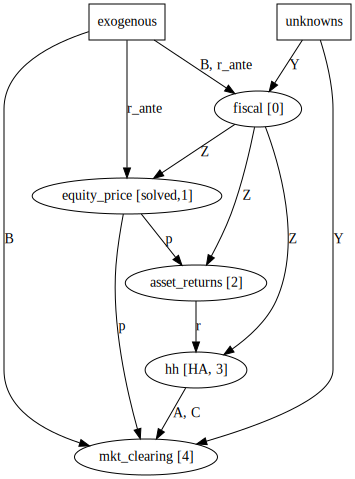

In [5]:
sj.drawdag(model_eq, exogenous=['B','r_ante'], unknowns=['Y'])

**Step 2**: Solve for the steady state

Recall that we want a steady state with $B=0$ so that the market portfolio is $100\%$ equity

In [6]:
calibration = dict(
    eis = 1.0,          # elasticity of intertemporal substitution
    rho_e = 0.96,       # persistence of idiosyncratic productivity shock
    sd_e = 0.92,        # stdev of idiosyncratic productivity
    nE = 11,            # number of productivity grid points
    nA = 1000,          # number of asset grid points
    amin = 0,           # min asset on grid
    amax = 1000,        # max asset on grid
    B = 0.0,            # government debt
    G = 0.0,            # government spending
    r_ante = 0.01,      # real interest rate
    mu = 1.02,          # markup
    Y = 1.0,            # Output
)
unknowns_ss = { 'beta': 0.957}
targets_ss = {'asset_mkt': 0.}

ss = m.model_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver='hybr')

We check that we found a reasonable calibration

In [7]:
ss['beta'], ss['p']/(4*ss['Y'])

(0.9569401173017015, 0.4901960784313736)

**Step 3**: Define inputs, unknowns, and targets

In [8]:
inputs = ['B', 'r_ante']
unknowns = ['Y']
targets = ['asset_mkt']

**Step 4**: Solve the model by getting all the GE Jacobians

In [9]:
T = 500
G_exo = model_eq.solve_jacobian(ss, unknowns, targets, inputs, T=T)

**Step 5**: Set the shock processes
- `dB`: deficit financed fiscal shock
- `dr_ante`: monetary policy shock

In [10]:
dB = 0.01*0.90**np.arange(T)
dr_ante = 1/4*0.01*0.9**np.arange(T)

At this point, we have the impulse responses to all shocks under exogenous portfolios

## 2. Perform the $\lambda$ test
If agents were allowed to pick optimal portfolios, then under complete markets they would equalize
$$
\frac{\mathbb{E}\left[u^{\prime}\left(c_0(a, e)\right) \mid e_{-1}\right]}{\mathbb{E}\left[u^{\prime}\left(c_{s s}(a, e)\right) \mid e_{-1}\right]}=\lambda_0
$$
We plot this statistic across the distribution to first order. Note that we have
$$
\lambda_0 = 1 + \frac{\mathbb{E}\left[u^{\prime\prime}\left(c_{ss}(a, e)\right) dc_0(a,e) \mid e_{-1}\right]}{\mathbb{E}\left[u^{\prime}\left(c_{s s}(a, e)\right) \mid  e_{-1}\right]}
$$

so we need a function that returns $dc_0(a,e)$ for any given shock, and then combines it with the relevant steady state information from $c_{ss}(a,e)$

In [11]:
def curlyc_0(shocked_input, ss, T, shock = 1.0, h=1e-4): 

    dc_0 = np.empty((T, ss['nE'], ss['nA'])) 

    ss_inputs = {k: ss.internals['hh'][k] for k in ('Va', 'Pi', 'a_grid', 'y')}
    ss_inputs_agg = {k: ss[k] for k in ('r','beta', 'eis')}
    ss_inputs = {**ss_inputs, **ss_inputs_agg}

    for s in range(T):
        if s == 0:
            # at horizon of s=0, 'shock' actually hits, override ss_inputs with shock
            shocked_inputs = {k: ss_inputs[k] + shock*h for k in shocked_input}
            Va, a, c = sim.backward_iteration(**{**ss_inputs, **shocked_inputs})
        else:
            # now the only effect is anticipation, so it's just Va being different
            Va, a, c = sim.backward_iteration(**{**ss_inputs, 'Va': Va})

        dc_0[s,:,:] = (c - ss.internals['hh']['c'])/h

    return dc_0

Now, we look at how this performs when the shocked input is the impulse response to a `B` shock. 


We first compute the $dc_0(a,e)$ in response to the general equilibrium $dr, dZ$ induced by the shock

In [12]:
dc_exo = {'r': curlyc_0('r',ss,T), 'Z': curlyc_0('y',ss,T, shock = 1/ss['mu']*ss.internals['hh']['e_grid'])}
dc_0_B = (dc_exo['r'].T @ (G_exo['r']['B'] @ dB) + dc_exo['Z'].T @ (G_exo['Z']['B'] @ dB)).T

We then combine this with $u'(c_{ss}(a,e))=c_{ss}(a,e)^{-1/\sigma-1}$ and $u''(c_{ss}(a,e))=-\frac{1}{\sigma}c_{ss}(a,e)^{-1/\sigma-1}$ to form 
$$
\lambda_0 = 1 + \frac{\mathbb{E}\left[u^{\prime\prime}\left(c_{ss}(a, e)\right) dc_0(a,e) \mid  e_{-1}\right]}{\mathbb{E}\left[u^{\prime}\left(c_{s s}(a, e)\right) \mid  e_{-1}\right]}
$$

In [13]:
css = ss.internals['hh']['c']
Pi = ss.internals['hh']['Pi']
sigma = ss['eis']
lambda_ratio_B = 1 + (Pi @ (-1/sigma*css**(-1/sigma-1)* dc_0_B) ) / (Pi @ (css**(-sigma)))

We now plot this: 

In [14]:
def income_comparison_fig(lambda_ratio, until=100):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(ss.internals['hh']['a_grid'][:until], lambda_ratio[2,:until], linewidth = 3, label='low income')
    ax.plot(ss.internals['hh']['a_grid'][:until], lambda_ratio[5,:until], linewidth = 3, label='middle income')
    ax.plot(ss.internals['hh']['a_grid'][:until], lambda_ratio[8,:until], linewidth = 3, label='high income')
    ax.legend()


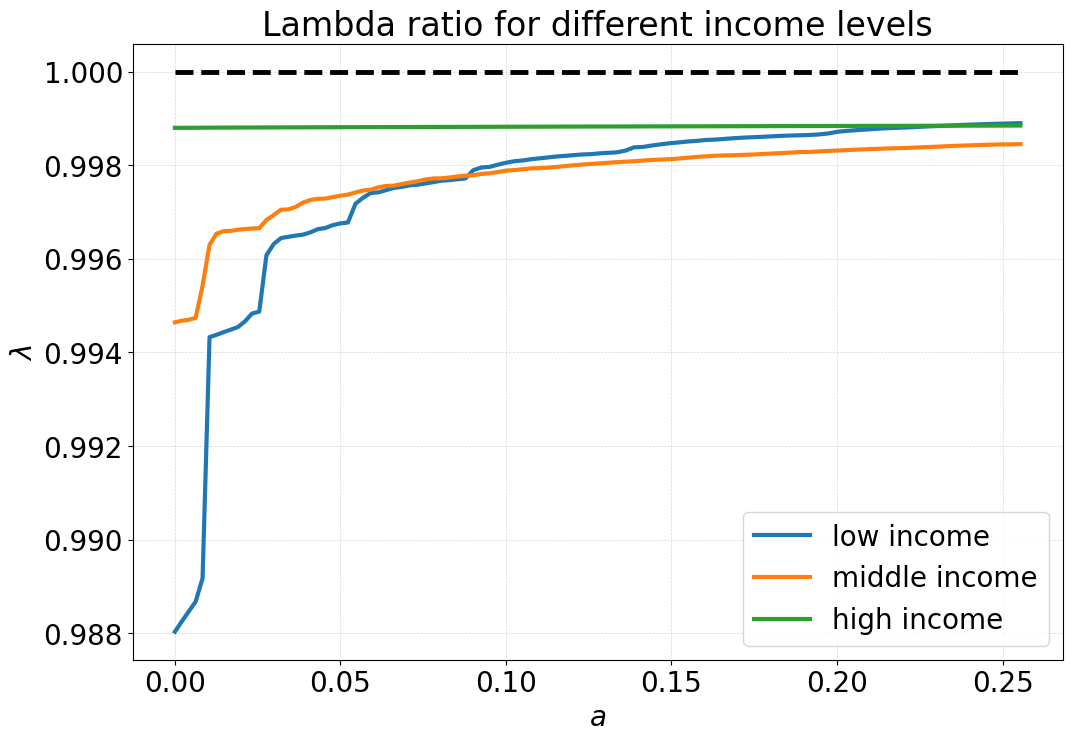

In [15]:
income_comparison_fig(lambda_ratio_B, 100)
plt.plot(ss.internals['hh']['a_grid'][:100], np.ones(100), color='black', linestyle='--')
plt.title('Lambda ratio for different income levels')
plt.xlabel(r'$a$')
plt.ylabel(r'$\lambda$');

We now do the same for the `r` shock

In [16]:
dc_0_r_ante = (dc_exo['r'].T @ (G_exo['r']['r_ante'] @ dr_ante) + dc_exo['Z'].T @ (G_exo['Z']['r_ante'] @ dr_ante)).T
lambda_ratio_r_ante = 1 + (Pi @ (-1/sigma*css**(-1/sigma-1)* dc_0_r_ante) ) / (Pi @ (css**(-sigma)))

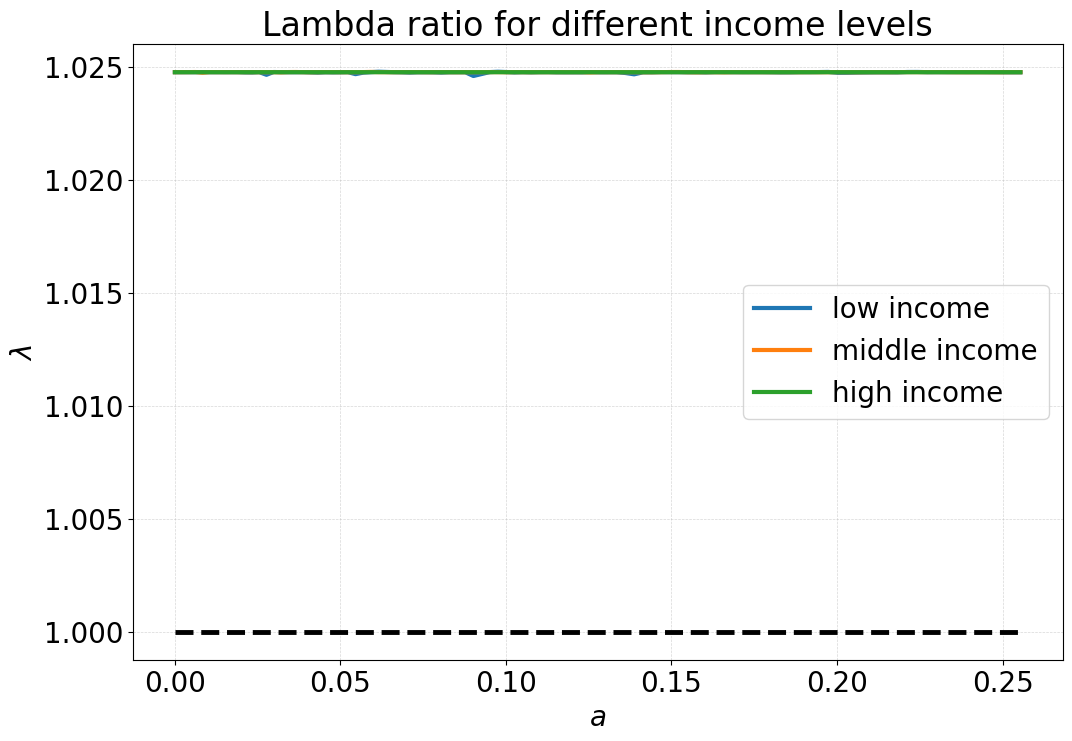

In [17]:
income_comparison_fig(lambda_ratio_r_ante, 100)
plt.plot(ss.internals['hh']['a_grid'][:100], np.ones(100), color='black', linestyle='--')
plt.title('Lambda ratio for different income levels')
plt.xlabel(r'$a$')
plt.ylabel(r'$\lambda$');

We see that for this shock, $\lambda$ is essentially equal among agents. 

This reflects the fact that the baseline equity portfolios are optimal, as discussed in the lecture.

## 3. Construct the complete markets correction


As shown in lecture, under complete markets, the households will hold portfolio positions such that for each each shock $z$ we have
$$
\frac{d W_i^{\prime}(\mathbf{0}) / W_i^{\prime}(\mathbf{0})}{d \epsilon_z}=\lambda_z \quad \forall i
$$
The transfers which deliver this are given by 
$$
\frac{d t_i}{d \epsilon_z}=\frac{\overline{W_i^{\prime}}(\mathbf{0})}{\overline{W_i^{\prime \prime}}(\mathbf{0})}\left(\lambda_z-\frac{d \overline{W_i^{\prime}}(\mathbf{0}) / \overline{W_i^{\prime}}(\mathbf{0})}{d \epsilon_Z}\right)
$$
and since the transfers have to sum to zero, we have
$$
\lambda_z=\left(\int \frac{\overline{W_i^{\prime}}(\mathbf{0})}{\overline{W_i^{\prime \prime}}(\mathbf{0})} d i\right)^{-1} \int \frac{\overline{W_i^{\prime}}(\mathbf{0})}{\overline{W_i^{\prime \prime}}(\mathbf{0})} \frac{d \overline{W_i^{\prime}}(\mathbf{0}) / \overline{W_i^{\prime}}(\mathbf{0})}{d \epsilon_z} d i )
$$

Hence, under complete markets with portfolio choice, we need to correct the impulse to shock $\epsilon_z$ using the transfers obtained from the above formula. Computing the correction is conceptually simple:
1. Obtain $\lambda_z$ from the above formula
2. Compute the transfers for each household indexed by idiosyncratic state $e$ and total savings $a$
3. Compute the evolution of aggregate spending if the initial distribution of wealth is corrected by the transfers relative to the steady state distribution of wealth

The implementation is offloaded to the `sim_portfolio_correction.py` script. To use it, we first update the steady state dictionary so that it includes the lotteries underlying the distribution update at each state $(a,e)$

In [18]:
# Add lotteries to the steady state
ss = sim_corr.ss_add_lotteries(ss)

To obtain the complete markets correction, we can use the ``jacobian_with_correction`` function from `sim_portfolio_correction.py`. The function takes as input the the steady state (with lotteries), the household inputs with respect to which we will obtain the Jacobian, and the length of the sequence considered. The function returns
- `HA`: the Jacobian of the model with respect to the household inputs
- `HA_corr`: the Jacobian correctection for complete markets
- `curlyT`: the transfers with respect to pertubations in the household inputs
- `curlyWa`: the changes in expected marginal utility with respect to pertubations in the household inputs 
- `dlambda`: the changes in cross-sectional SDF with respect to pertubations in the household inputs

The first two objects are used to solve the model with complete markets. The transfers are useful for obtain the portfolios under complete markets. The changes in cross-sectional SDF are useful for obtaining risk premia. 

To call the correction, we need to specify the household inputs with respect to which we will obtain the Jacobian. The household inputs are specified as a list of strings. In our case, the inputs are the income `y` and the return on the baseline (exogenous) portfolio `r`. 

We want to know how the household block respond to changes in disposable income `Z` and the return on the baseline portfolio `r`. In our setting, the change in disposable income by 1 unit is equal to shifting the household income $y$ by $\frac{1}{\mu} \times e$ units.

In [19]:
HA, HA_corr, curlyT, curlyWa, dlambda = sim_corr.jacobian_with_correction(ss, {'Z': {'y': 1/ss['mu']*ss.internals['hh']['e_grid']}, 'r': {'r': 1}},T) 

Now, following the lecture, we replace the household block by a **modified household block** that includes the complete-markets correction. 

To do this, we can use the ``JacobianDict`` and the ``JacobianDictBlock`` classes.

In [20]:
from sequence_jacobian.blocks.auxiliary_blocks.jacobiandict_block import JacobianDictBlock

household_corr = sj.JacobianDict({'C': {'r': HA['C']['r'] + HA_corr['C']['r'], 'Z': HA['C']['Z'] + HA_corr['C']['Z']},
                             'A': {'r': HA['A']['r'] + HA_corr['A']['r'], 'Z': HA['A']['Z'] + HA_corr['A']['Z']}})
household_corr = JacobianDictBlock(household_corr)
household_corr.name = 'corrected hh'

We now create a modified model that replaces the household block simply with `household_corr`

In [21]:
model_corr = sj.create_model([household_corr,     # Household block
                            m.mkt_clearing,       # Asset and goods market clearing
                            m.fiscal,             # Fiscal policy
                            m.equity_price,       # Solved block for equity price
                            m.asset_returns,      # Returns the return on equity r_eq, return on real debt r_real, and return on portfolio r = r_eq
                          ], name="Complete markets model")


We solve the model as usual by calling the ``solve_jacobian`` function.

In [22]:
''' Solve the model with endogenous portfolios '''
G_endo = model_corr.solve_jacobian(ss, unknowns, targets, inputs, T=T)

Using the Jacobian correction, we can create a modified **household block** that includes the correction. For that purpose, we can use the ``JacobianDict`` and the ``JacobianDictBlock`` classes.

In [23]:
from sequence_jacobian.blocks.auxiliary_blocks.jacobiandict_block import JacobianDictBlock

household_corr = sj.JacobianDict({'C': {'r': HA['C']['r'] + HA_corr['C']['r'], 'Z': HA['C']['Z'] + HA_corr['C']['Z']},
                             'A': {'r': HA['A']['r'] + HA_corr['A']['r'], 'Z': HA['A']['Z'] + HA_corr['A']['Z']}})
household_corr = JacobianDictBlock(household_corr)
household_corr.name = 'corrected hh'

Now we can create a model which replace the old household block with the corrected one. 

In [24]:
model_corr = sj.create_model([household_corr,     # Household block
                            m.mkt_clearing,       # Asset and goods market clearing
                            m.fiscal,             # Fiscal policy
                            m.equity_price,       # Solved block for equity price
                            m.asset_returns,      # Returns the return on equity r_eq, return on real debt r_real, and return on portfolio r = r_eq
                          ], name="Equity baseline and real gov debt: complete markets correction")

We solve the model as usual by calling the ``solve_jacobian`` function.

In [25]:
''' Solve the model with endogenous portfolios '''
G_endo = model_corr.solve_jacobian(ss, unknowns, targets, inputs, T=T)

That's it! We have the general equilibrium model with endogenous portfolios. To test it out, we first compare the impulse responses to exogenous and endogenous portfolios

In [26]:
# Compute the exogenous portfolio IRFs
dY_B_exo = G_exo['Y']['B'] @ dB
dY_r_ante_exo = G_exo['Y']['r_ante'] @ dr_ante

# Compute the endogenous complete markets portfolio IRFs
dY_B_cm = G_endo['Y']['B'] @ dB
dY_r_ante_cm = G_endo['Y']['r_ante'] @ dr_ante

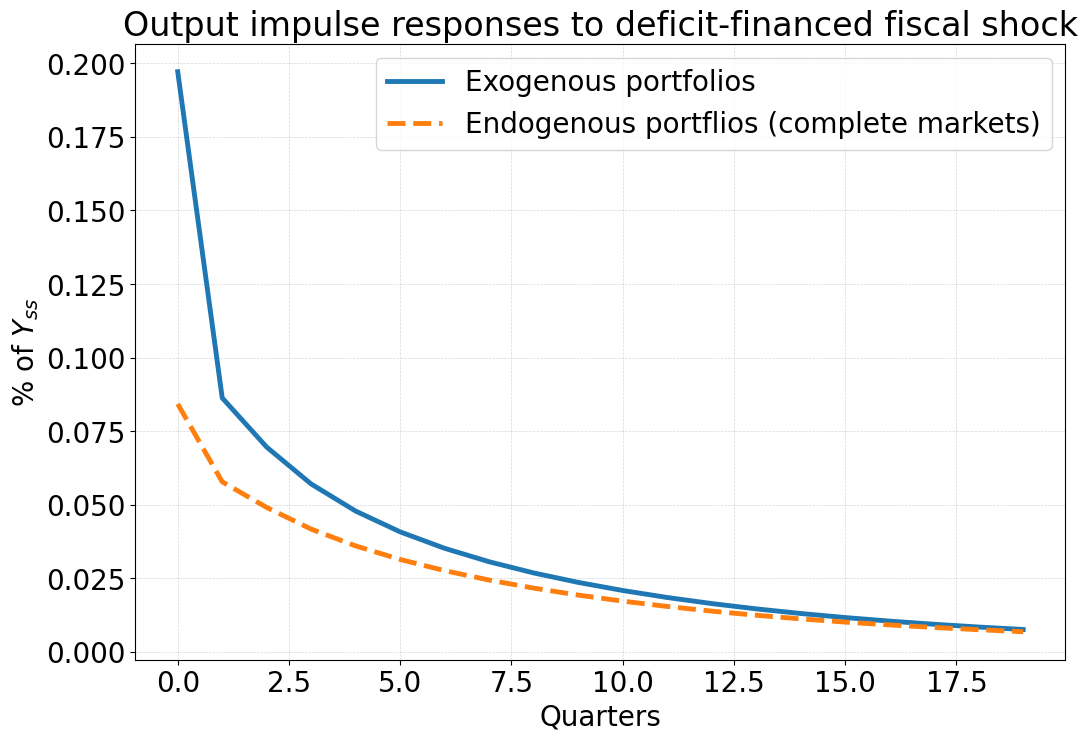

In [27]:
plt.plot(dY_B_exo[:20]*100, label='Exogenous portfolios')
plt.plot(dY_B_cm[:20]*100, '--', label='Endogenous portflios (complete markets)')
plt.title('Output impulse responses to deficit-financed fiscal shock')
plt.xlabel('Quarters')
plt.ylabel(r'% of $Y_{ss}$')
plt.legend();

As expected from the lambda test, the complete markets correction implements optimal hedging by redistributing away from poor agents when $B$ increases, which mitigates the expansion from deficit-financed fiscal shock. 

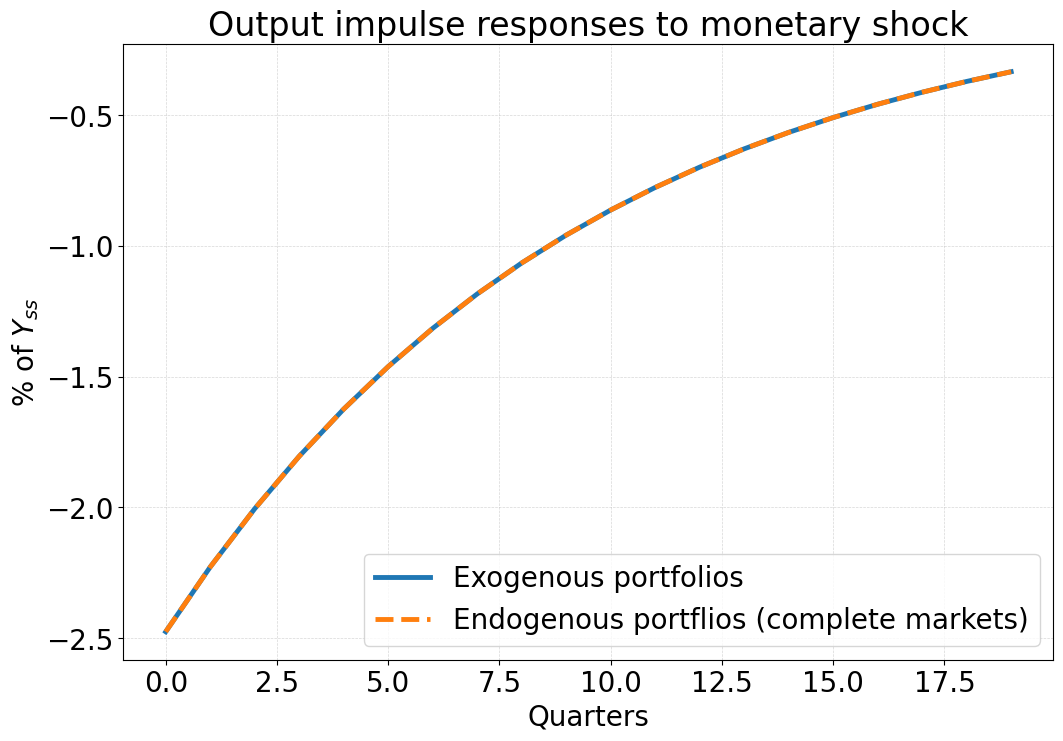

In [28]:
plt.plot(dY_r_ante_exo[:20]*100, label='Exogenous portfolios')
plt.plot(dY_r_ante_cm[:20]*100, '--', label='Endogenous portflios (complete markets)')
plt.title('Output impulse responses to monetary shock')
plt.xlabel('Quarters')
plt.ylabel(r'% of $Y_{ss}$')
plt.legend();

By contrast, we see that the monetary policy impulse response is the same as with exogenoous portfolios, reflecting the fact that the portfolios are in fact optimal

## 5. Recover the complete-market transfers and sustaining portfolios

Using the changes in returns on assets and the transfers, we can figure out what positions would allow households to replicate the complete market transfers. Note that if we have too many assets, we can get indeterminacy in portfolios, as there are multiple ways to replicate the transfers. But if we have one shock and two assets, we can uniquely determine the portfolio positions. Here, we consider our baseline case with equity and real one-period bonds.

We'll use the `curlyT` objects from the `jacobian_with_correction` routine.

In [29]:
print(curlyT['r'].shape)

(500, 11, 1000)


##### Deficit financed fiscal shock

In [30]:
transfers = curlyT['r'].T @ (G_endo['r']['B'] @ dB) + curlyT['Z'].T @ (G_endo['Z']['B'] @ dB)
transfers = transfers.T

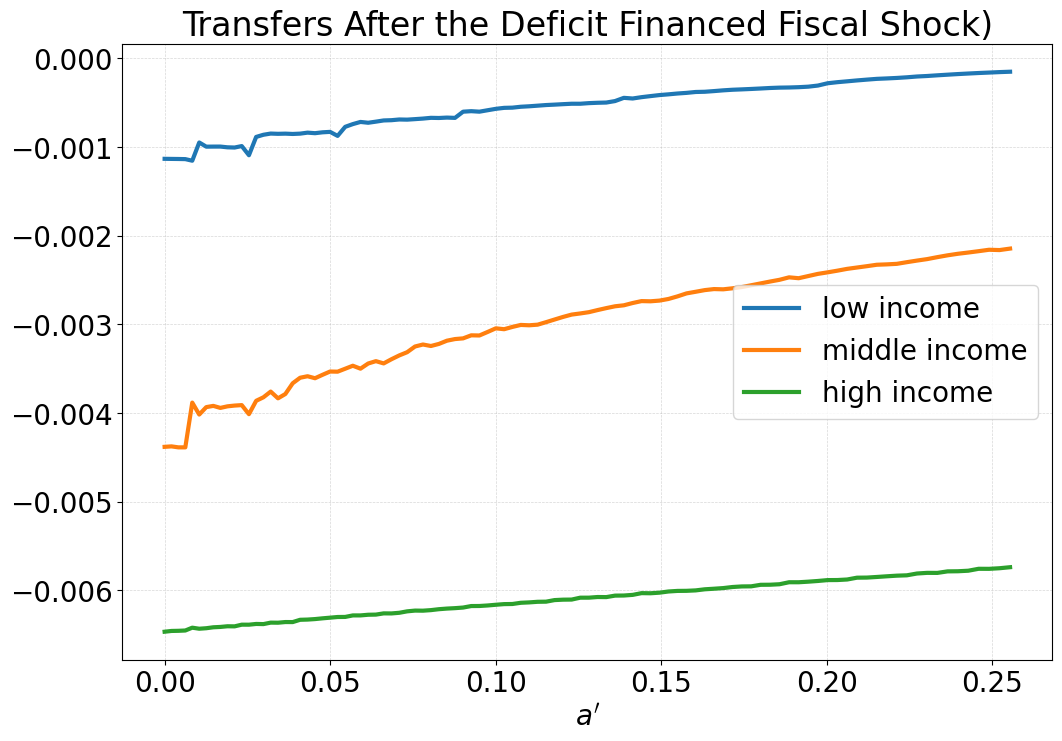

In [31]:
income_comparison_fig(transfers)
plt.title('Transfers After the Deficit Financed Fiscal Shock)')
plt.xlabel(r'$a^{\prime}$');

What is the position in equity the household would need to hold to obtain the transfer? To get the transfer $t$, the household would need to hold *relative to baseline* a position in equity equal to $t/dr_0^{\mathrm{eq}}$. Since the baseline is $100\%$ in equity, the position in equity is therefore $a' + t/dr_0^{\mathrm{eq}}$.

In [32]:
dr_eq = G_endo['r_eq']['B'] @ dB
eq = ss.internals['hh']['a_grid'][np.newaxis, :] + transfers / dr_eq[0]
eq_share = eq[:,1:]/ss.internals['hh']['a_grid'][np.newaxis, 1:]

In [33]:
def portfolio_share_fig(eq_share, until=400):
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(ss.internals['hh']['a_grid'][1:until+1], eq_share[2,:until], linewidth = 3, label='low income')
    ax.plot(ss.internals['hh']['a_grid'][1:until+1], eq_share[5,:until], linewidth = 3, label='middle income')
    ax.plot(ss.internals['hh']['a_grid'][1:until+1], eq_share[8,:until], linewidth = 3, label='high income')
    ax.legend()
    ax.set_title('Fraction of portfolio in equity')
    ax.set_xlabel('Asset choice for the next period $a^\prime$')
    ax.set_ylabel('Fraction invested in equity')
    plt.show()

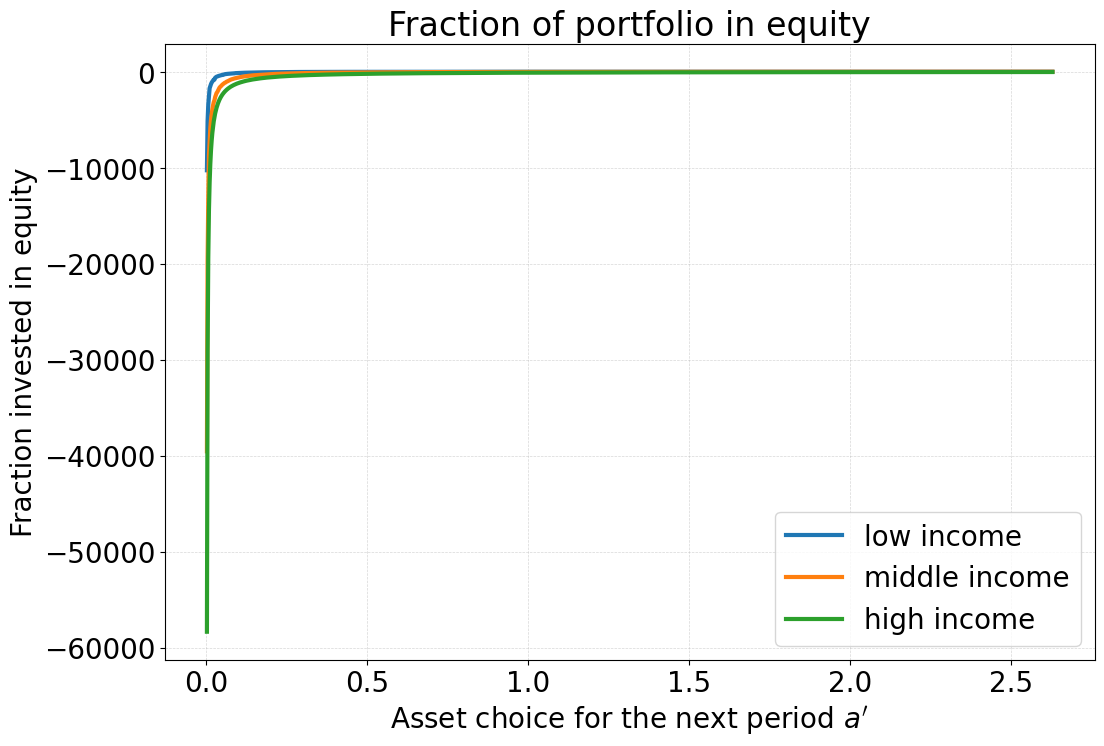

In [34]:
portfolio_share_fig(eq_share)

We do the same with a monetary policy shock:

In [35]:
transfers_r_ante = curlyT['r'].T @ (G_endo['r']['r_ante'] @ dr_ante) + curlyT['Z'].T @ (G_endo['Z']['r_ante'] @ dr_ante)
transfers_r_ante = transfers_r_ante.T
dr_eq_r_ante = G_endo['r_eq']['r_ante'] @ dr_ante
eq_r_ante = ss.internals['hh']['a_grid'][np.newaxis, :] + transfers_r_ante / dr_eq_r_ante[0]
eq_share_r_ante = eq_r_ante[:,1:]/ss.internals['hh']['a_grid'][np.newaxis, 1:]

(-0.003, 0.003)

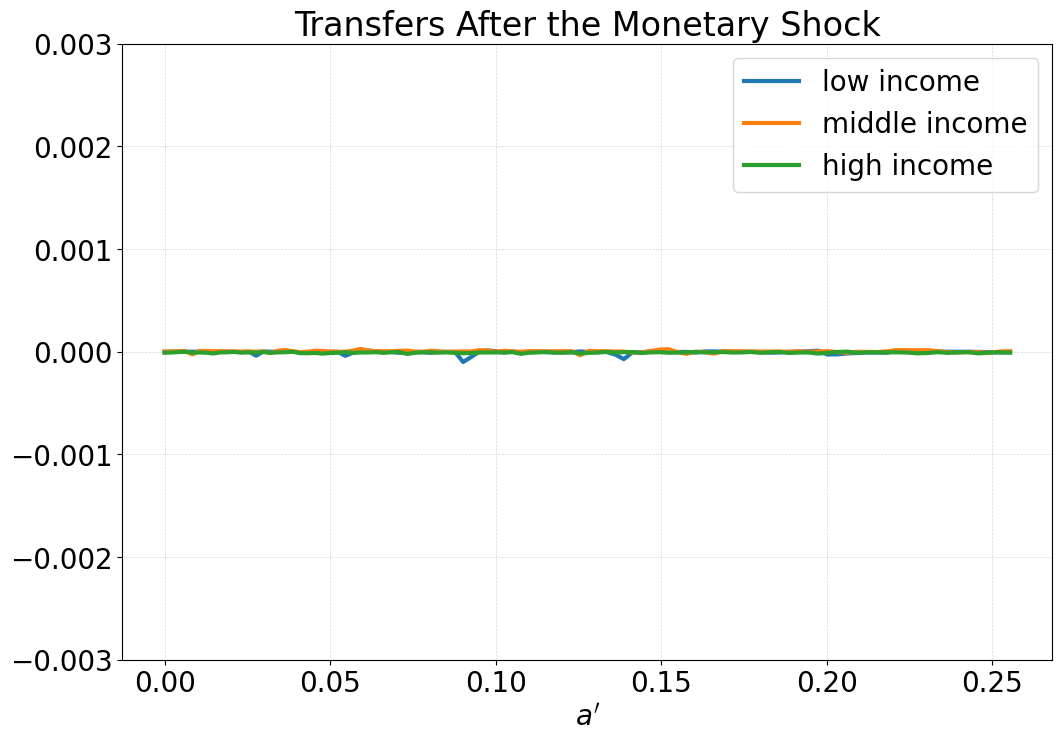

In [36]:
income_comparison_fig(transfers_r_ante)
plt.title('Transfers After the Monetary Shock')
plt.xlabel(r'$a^{\prime}$')
plt.ylim(-0.003, 0.003)

Text(0.5, 0, '$a^{\\prime}$')

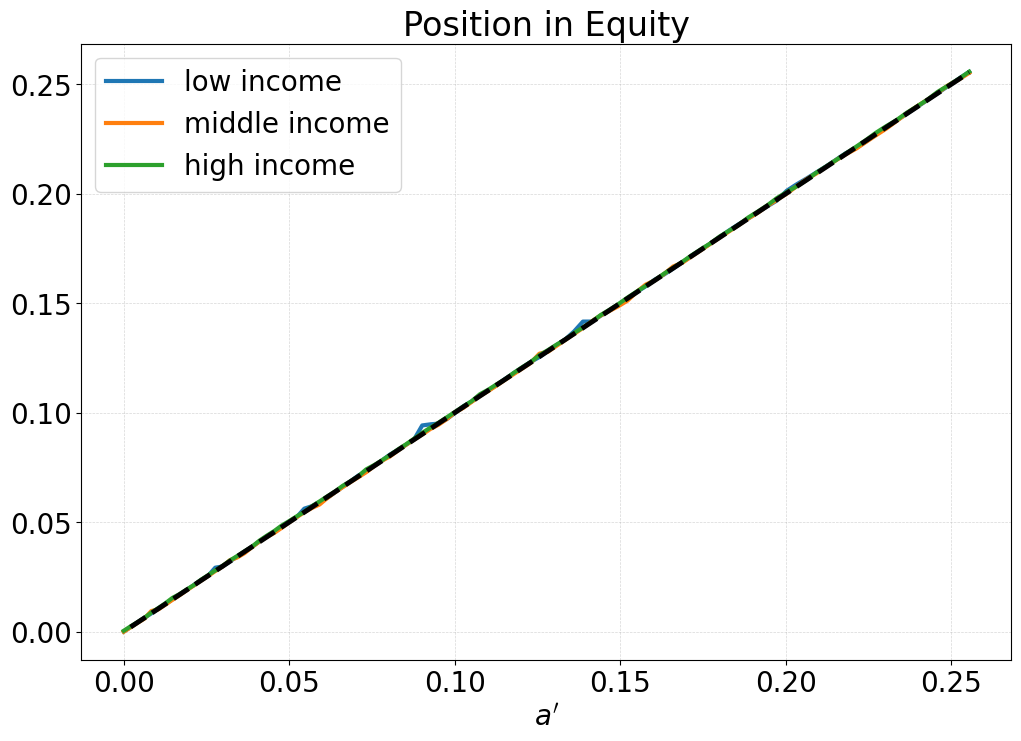

In [37]:
income_comparison_fig(eq_r_ante)
plt.title('Position in Equity')
# add a 45 degree line
plt.plot(ss.internals['hh']['a_grid'][1:100], ss.internals['hh']['a_grid'][1:100], color='black', linestyle='--')
plt.xlabel(r'$a^{\prime}$')

## 6. Recover the steady-state risk premia
Finally, we recover the risk premia. 

As shown in lecture, the second order approximation of risk premia is given by
$$
\begin{aligned}
\frac{R^k(\sigma)-R^{\circ}(\sigma)}{R} & \approx\left(r^k-r^{\circ}\right) \sigma^2 \\
& \approx-\operatorname{Cov}\left(\lambda(\bar{\epsilon}), X^k(\bar{\epsilon})-X^{\circ}(\bar{\epsilon})\right) \sigma^2
\end{aligned}
$$
We obtain $\lambda(\bar{\epsilon})$ by taking a product of `curlyLambda` and the equilibrium sequences of household inputs. 

In [38]:
lambda_total = dlambda['r'] @ G_endo['r']['B'] @ dB + dlambda['Z'] @ G_endo['Z']['B'] @ dB

risk_premium_eq = - lambda_total * dr_eq[0]  / (1+ss['r'])

print('Risk premium on equity: ', risk_premium_eq)

Risk premium on equity:  3.882335493241912e-08


For the monetary shock, we would obtain the risk premium as

In [39]:
lambda_total_r_ante = dlambda['r'] @ G_endo['r']['r_ante'] @ dr_ante + dlambda['Z'] @ G_endo['Z']['r_ante'] @ dr_ante

risk_premium_eq_r_ante = - lambda_total_r_ante * dr_eq_r_ante[0] / (1+ss['r'])

print('Risk premium on equity: ', risk_premium_eq_r_ante)

Risk premium on equity:  0.0006126450343645339


That's it! We solved for impulse responses with endogenous portfolios, as well as sustaining portfolios and risk premia, essentially as easily as with any other model in SSJ. 